## Milling Tool Wear Maintenance Policy using the REINFORCE algorithm

- Ver. 4.1: 01-May-2023 - Improved plots
- Ver. 4.5: 01-May-2023 - Add Stable-Baselines algo.
- Ver. 4.6: 02-May-2023 - Expt RF vs SB-3 PPO, scaled rewards: 1/10^6 
- Ver. 4.8: 06-May-2023 - Auto run SB3 algos.
- Ver. 5.0: 06-May-2023 - Re-factor. Functions conversions to enable test runs.
- Ver. 5.1: 07-May-2023 - PPO behaviour. For SB-3 models, correct test set reshuffle and retraining of models everytime 
- Ver. 5.2: 07-May-2023 - Test cases sample 40 (constant) and _without_ replacement
- Ver. 5.3: 08-May-2023 - Do not sort Test cases. Possible cause of trends in ppo?
- Ver. 6.0: 08-May-2023 - Train once, save model, test multiple times. Block storing of model training progress
- Ver. 6.1: 08-May-2023 - Add pr., rc., f1 scores
- Ver. 6.2: 08-May-2023 - Fix div. by zero warnings
- Ver. 7.0: 09-May-2023 - Introduced two functions to compute algo. level aggregated metrics and save to a file
- Ver. 7.5: 10-May-2023 - Adapt for PHM data. Columns cloned in PHM original data: ```timestamp -> time,  tool_wear -> VB_mm, New added column -> ACTION_CODE```
- Ver. 8.0: 10-May-2023 - PHM data - 3 tests
- Ver. 8.1: 11-May-2023 - Towards complex env. state. Remove VB_mm etc. Adapt to PHM naming
- Ver. 8.2: 12-May-2023 - Add F1 along with F1-Beta
- Ver. 8.3: 12-May-2023 - **** MAJOR BUG. Pr. Rc computed in for loop rather than outside. Add Beta for F1-Beta for higher precision = lower FP = lower "replace" errors
- Ver. 8.4: 12-May-2023 - Added metrics method control. Default is "weigthed"
- Ver. 8.5: 12-May-2023 - Reward signal modified - penalty for replacements increased from -100 to -150
- Ver. 8.6: 13-May-2023 - Revise code to work with both Simple and Complex envs. Test with PHM DATA C01, with noise
- Ver. 8.7: 13-May-2023 - Re-run all experiments
- Ver. 8.8: 13-May-2023 - (Network arch improved for PolicyNetwork.) Redcued back to basic 
- Ver. 8.9: 15-May-2023 - Rename report and plot files as PHM-C01_LowNBD_WT_N_BD_Ep_Terminate, Sim_NoNBD_WT_N_BD_Ep_Terminate. Add sub-titles to plots.
- Ver. 8.91: 16-May-2023 - Stable version. Reward signal: V.3.96. +1*indx, -1.2*idx and -4.0. Best RF. F1=0.540. Normal err=0.16. Rep. err:0.69
- Ver. 8.92: Env: V.3.97 Reward . +1*indx, -1.2*idx and -3.0 > Err switched. Normal: 1.00 Rep.=0.00	
- 8.93: repl penalty = abs(wear-threshold)  << BEST
- 8.94: TRY 0.5*abs(wear-threshold)
- 9.0: MillingEnv added _MS_V2 to take in R1, R2 and R3 reward signal parameters

In [1]:
import numpy as np
import pandas as pd

import milling_tool_environment
import utilities
from milling_tool_environment import MillingTool_SS_V2, MillingTool_MS_V2
from utilities import compute_metrics, compute_metrics_simple, write_metrics_report, store_results, plot_learning_curve, single_axes_plot
from utilities import two_axes_plot, two_variable_plot, plot_error_bounds, test_script, write_test_results, downsample
from reinforce_classes import PolicyNetwork, Agent

import datetime
dt = datetime.datetime.now()
dt_d = dt.strftime('%d-%b-%Y')
dt_t = dt.strftime('%H_%M_%S')
dt_m = dt.strftime('%H%M')

In [2]:
import importlib
importlib.reload(milling_tool_environment)
importlib.reload(utilities)
from milling_tool_environment import MillingTool_SS, MillingTool_MS

In [3]:
# env = MillingTool_MS(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE)

In [4]:
# Version name: <Ver.No>_Sim_<N or W>NB_<episodes>_test-run
# Data Files: Simulated_Dasic_2006_Tool_Wear_Model. Threshold 3mm
# PHM:        PHM_C01_MultiStateEnv_0p12; PHM_C04_MultiStateEnv_0p0975; PHM_C06_MultiStateEnv_0p13

ENVIRONMENT_INFO = 'PHM 2006. Multi-var state V2.'
DATA_FILE = 'data\PHM_C01_MultiStateEnv_0p12.csv'
WEAR_THRESHOLD = 0.11 # mm
ADD_NOISE = 1e3 # 0 for no noise. Factor to apply on np.random.rand(). For e.g. 1e2 or 1e3 are factors for higher and lower noise. 
BREAKDOWN_CHANCE = 0.05 # Recommended: 0.05 = 5%
EPISODES = 1_200 # Train for N episodes. # Suggested 600

## Read data
df = pd.read_csv(DATA_FILE)
n_records = len(df.index)
# MILLING_OPERATIONS_MAX = 800
MILLING_OPERATIONS_MAX = n_records-1 # Suggested 300
# MILLING_OPERATIONS_MAX = 800

if ADD_NOISE == 1e3 and BREAKDOWN_CHANCE == 0.05:
    lnoise = 'LowNBD'
elif ADD_NOISE == 1e2  and BREAKDOWN_CHANCE == 0.10:
    lnoise = 'HighNBD'
elif ADD_NOISE <= 0 and BREAKDOWN_CHANCE == 0:
    lnoise = 'NoNBD'
else:
    lnoise = 'ArbNBD'

VERSION = f'PHM-MS-C01_{lnoise}_{WEAR_THRESHOLD}_{EPISODES}_{MILLING_OPERATIONS_MAX}'

###########################################################################################################################

METRICS_METHOD = 'weighted' # average method = {‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’} 
TEST_INFO = 'Sampled from training data'
TEST_CASES = 40
TEST_ROUNDS = 5
# Milling operation constants
WEAR_THRESHOLD_NORMALIZED = 0.0 # normalized to the max wear threshold

# Policy network learning parameters
gamma = 0.99
alpha = 0.01

RESULTS_FOLDER = 'results/18-May-2023'
CONSOLIDATED_METRICS_FILE = f'{RESULTS_FOLDER}/CONSOLIDATED_METRICS.csv'
RESULTS_FILE = f'{RESULTS_FOLDER}/{VERSION}_test_results_{dt_d}_{dt_m}.csv'
METRICS_FILE = f'{RESULTS_FOLDER}/{VERSION}_metrics.csv'

# RESULTS_FILE = f'results/13-May-2023/{VERSION}_test_results_{dt_d}-{dt_m}.csv'
# METRICS_FILE = f'results/13-May-2023/{VERSION}_metrics_{dt_d}-{dt_m}.csv'

print('\n -- Columns added to results file ', RESULTS_FILE)
results = ['Date', 'Time', 'Round', 'Environment', 'Training_data', 'Wear_Threshold', 'Test_data', 'Algorithm', 'Episodes', 'Normal_cases', 'Normal_error', 
           'Replace_cases', 'Replace_error', 'Overall_error', 
           'Wtd_Precision', 'Wtd_Recall', 'F_Beta_0_5', 'F_Beta_0_75', 'F_1_Score']
write_test_results(results, RESULTS_FILE)


 -- Columns added to results file  results/18-May-2023/PHM-MS-C01_LowNBD_0.11_1200_347_test_results_19-May-2023_1004.csv


Tool wear data imported (348 records). WEAR_THRESHOLD_NORMALIZED: 0.494 




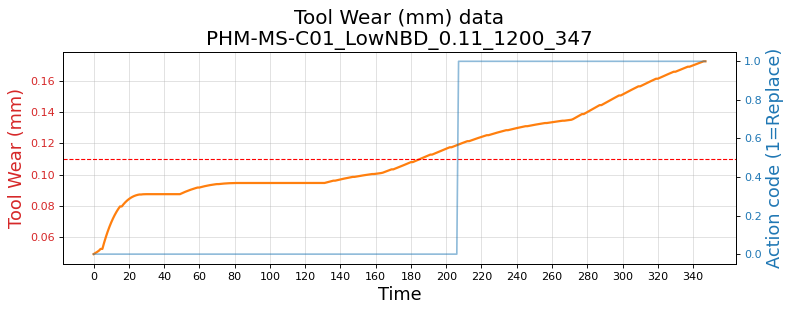

In [5]:
# Normalizing entire df with min-max scaling
WEAR_MIN = df['tool_wear'].min() 
WEAR_MAX = df['tool_wear'].max()
WEAR_THRESHOLD_NORMALIZED = (WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
df_normalized['ACTION_CODE'] = df['ACTION_CODE']
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f} \n\n')

# Visualize the data
# df.plot(figsize = (10, 6))

x = [n for n in range(n_records)]
y1 = df['tool_wear'].values.tolist()
y2 = df['ACTION_CODE'].values.tolist()
wear_plot = f'{RESULTS_FOLDER}/{VERSION}_wear_plot.png'
title=f'Tool Wear (mm) data\n{VERSION}'
two_axes_plot(x, y1, y2, title=title, x_label='Time', 
              y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', xticks=20, file=wear_plot, threshold=WEAR_THRESHOLD)

In [6]:
env = MillingTool_MS_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE, 1.0, -1.0, -100.0)


** -- Multi-variate state V2 env. R1: 1.0, R2: -1.0, R3: -100.0. Noise: 1000.0. Break-down chance: 0.05 -- **



## Milling Tool Environment - 
1. MillingTool_SS: Single state: tool_wear and time
2. MillingTool_MS: Multie-state: force_x; force_y; force_z; vibration_x; vibration_y; vibration_z; acoustic_emission_rms; tool_wear
- Note: ACTION_CODE is only used for evaluation later (testing phase) and is NOT passed as part of the environment states

## REINFORCE RL Algorithm

In [7]:
### Main loop
rewards_history = []
loss_history = []
training_stats = []

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent_RF = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env.reset()

    # Sample a trajectory
    for t in range(MILLING_OPERATIONS_MAX): # Max. milling operations desired
        action = agent_RF.act(state)
        state, reward, done, info = env.step(action)
        agent_RF.rewards.append(reward)
        #env.render()
        if done:
            # print('** DONE **', info)
            break

    # Learn during this episode 
    loss = agent_RF.learn() # train per episode
    total_reward = sum(agent_RF.rewards)

    # Record statistics for this episode
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting

    # On-policy - so discard all data 
    agent_RF.onpolicy_reset()

    if (episode%100 == 0):
        # print(f'[{episode:04d}] Loss: {loss:>10.2f} | Reward: {total_reward:>10.2f} | Ep.length: {env.ep_length:04d}')
        print(f'[{episode:04d}] Loss: {loss:>10.2e} | Reward: {total_reward:>10.2e} | Ep.length: {env.ep_length:04d}')

[0000] Loss:  -1.61e+02 | Reward:  -2.68e+00 | Ep.length: 0347
[0100] Loss:   3.89e+00 | Reward:   1.95e+00 | Ep.length: 0278
[0200] Loss:   1.83e-01 | Reward:   1.76e+00 | Ep.length: 0267
[0300] Loss:   1.71e-02 | Reward:   1.43e+00 | Ep.length: 0210
[0400] Loss:   6.32e-03 | Reward:   1.40e+00 | Ep.length: 0208
[0500] Loss:   3.48e-02 | Reward:   1.16e+00 | Ep.length: 0191
[0600] Loss:   8.54e-01 | Reward:   1.58e+00 | Ep.length: 0224
[0700] Loss:   1.23e-02 | Reward:   1.68e+00 | Ep.length: 0237
[0800] Loss:   1.53e-02 | Reward:   1.29e+00 | Ep.length: 0200
[0900] Loss:   9.02e+00 | Reward:   3.04e+00 | Ep.length: 0347
[1000] Loss:   1.16e+01 | Reward:   1.39e+00 | Ep.length: 0347
[1100] Loss:   1.40e+01 | Reward:   9.49e-01 | Ep.length: 0347


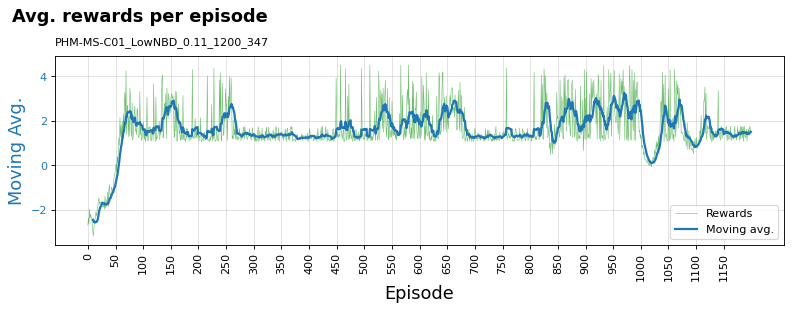

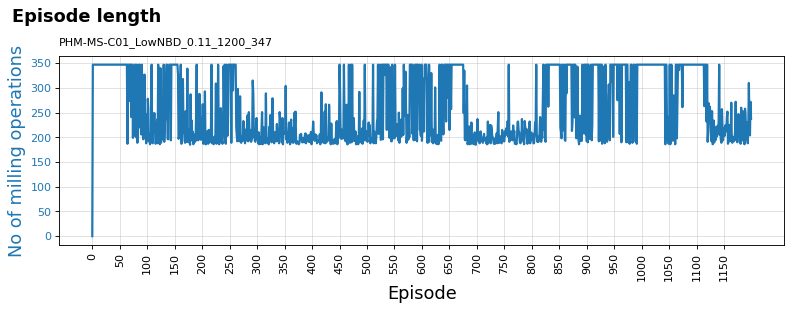

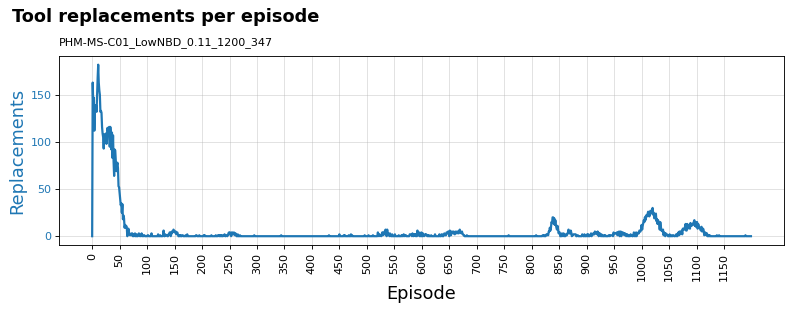

In [8]:
x = [i for i in range(EPISODES)]

## Moving average for rewards
ma_window_size = 10
# # Convert error array to pandas series
rewards = pd.Series(rewards_history)
windows = rewards.rolling(ma_window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
y1 = rewards
y2 = moving_avg_lst

filename = f'{RESULTS_FOLDER}/{VERSION}_Avg_episode_rewards.png'
two_variable_plot(x, y1, y2, 'Avg. rewards per episode', VERSION, 'Episode', 'Avg. Rewards', 'Moving Avg.', 50, filename)

# plot_error_bounds(x, y1)

filename = f'{RESULTS_FOLDER}/{VERSION}_Episode_Length.png'
single_axes_plot(x, env.ep_length_history, 'Episode length', VERSION, 'Episode', 'No of milling operations', 50, 0.0, filename)

filename = f'{RESULTS_FOLDER}/{VERSION}_Tool_Replacements.png' 
single_axes_plot(x, env.ep_tool_replaced_history, 'Tool replacements per episode', VERSION, 'Episode', 'Replacements', 50, 0.0, filename)


### Generate a balanced test set

In [9]:
idx_replace_cases = df.index[df['ACTION_CODE'] >= 1.0]
idx_normal_cases = df.index[df['ACTION_CODE'] < 1.0]

In [10]:
# Process results
# eps = [i for i in range(EPISODES)]
# store_results(RF_TRAINING_FILE, training_round, eps, rewards_history, env.ep_tool_replaced_history)
print('\n === REINFORCE model trained ===\n')
print(80*'-')
print(f'Algorithm\tNormal\terr.%\tReplace\terr.%\tOverall err.%')
print(80*'-')
for test_round in range(TEST_ROUNDS):
    # Create test cases
    idx_replace_cases = np.random.choice(idx_replace_cases, int(TEST_CASES/2), replace=False)
    idx_normal_cases = np.random.choice(idx_normal_cases, int(TEST_CASES/2), replace=False)
    test_cases = [*idx_normal_cases, *idx_replace_cases]
    
    results = test_script(METRICS_METHOD, test_round, df_normalized, 'REINFORCE', EPISODES, env, ENVIRONMENT_INFO, agent_RF, 
                          test_cases, TEST_INFO, DATA_FILE, WEAR_THRESHOLD, RESULTS_FILE)
    write_test_results(results, RESULTS_FILE)
    
print(f'\n- Test results written to file: {RESULTS_FILE}')


 === REINFORCE model trained ===

--------------------------------------------------------------------------------
Algorithm	Normal	err.%	Replace	err.%	Overall err.%
--------------------------------------------------------------------------------
REINFORCE	20	0.000	20	1.000	0.500
REINFORCE	20	0.000	20	1.000	0.500
REINFORCE	20	0.000	20	1.000	0.500
REINFORCE	20	0.000	20	1.000	0.500
REINFORCE	20	0.000	20	1.000	0.500

- Test results written to file: results/18-May-2023/PHM-MS-C01_LowNBD_0.11_1200_347_test_results_19-May-2023_1004.csv


## Stable-Baselines Algorithms

In [11]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

In [12]:
algos = ['A2C','DQN','PPO']

SB_agents = []

for SB_ALGO in algos:
    if SB_ALGO.upper() == 'A2C': agent_SB = A2C('MlpPolicy', env)
    if SB_ALGO.upper() == 'DQN': agent_SB = DQN('MlpPolicy', env)
    if SB_ALGO.upper() == 'PPO': agent_SB = PPO('MlpPolicy', env)
    
    print(f'\n{SB_ALGO} - Training and Testing Stable-Baselines-3 {SB_ALGO} algorithm')
    agent_SB.learn(total_timesteps=EPISODES)

    SB_agents.append(agent_SB)
    print(agent_SB)


A2C - Training and Testing Stable-Baselines-3 A2C algorithm

DQN - Training and Testing Stable-Baselines-3 DQN algorithm

PPO - Training and Testing Stable-Baselines-3 PPO algorithm


In [13]:
n = 0
for agent_SB in SB_agents:
    print(f'\n\n - Testing Stable-Baselines-3 {agent_SB}')
    print(80*'-')
    print(f'Algo.\tNormal\tErr.%\tReplace\tErr.%\tOverall err.%')
    print(80*'-')
    for test_round in range(TEST_ROUNDS):
        # Create test cases
        idx_replace_cases = np.random.choice(idx_replace_cases, int(TEST_CASES/2), replace=False)
        idx_normal_cases = np.random.choice(idx_normal_cases, int(TEST_CASES/2), replace=False)
        test_cases = [*idx_normal_cases, *idx_replace_cases]
        results = test_script(METRICS_METHOD, test_round, df_normalized, algos[n], EPISODES, env, ENVIRONMENT_INFO, 
                              agent_SB, test_cases, TEST_INFO, DATA_FILE, WEAR_THRESHOLD, RESULTS_FILE)
        write_test_results(results, RESULTS_FILE)
    n += 1



 - Testing Stable-Baselines-3 <stable_baselines3.a2c.a2c.A2C object at 0x00000254AC8F8EB0>
--------------------------------------------------------------------------------
Algo.	Normal	Err.%	Replace	Err.%	Overall err.%
--------------------------------------------------------------------------------
A2C	20	0.000	20	1.000	0.500
A2C	20	0.000	20	1.000	0.500
A2C	20	0.000	20	1.000	0.500
A2C	20	0.000	20	0.900	0.450
A2C	20	0.000	20	1.000	0.500


 - Testing Stable-Baselines-3 <stable_baselines3.dqn.dqn.DQN object at 0x00000254A5B81AC0>
--------------------------------------------------------------------------------
Algo.	Normal	Err.%	Replace	Err.%	Overall err.%
--------------------------------------------------------------------------------
DQN	20	1.000	20	0.000	0.500
DQN	20	1.000	20	0.000	0.500
DQN	20	1.000	20	0.050	0.525
DQN	20	0.900	20	0.000	0.450
DQN	20	0.950	20	0.000	0.475


 - Testing Stable-Baselines-3 <stable_baselines3.ppo.ppo.PPO object at 0x00000254AC940520>
-----------------------

### Create a consolidated algorithm wise metrics summary

In [14]:
print(80*'-', f'\n Algorithm level consolidated metrics being reported to file:\n {METRICS_FILE}\n', 80*'-')

header_columns = [VERSION]
write_test_results(header_columns, METRICS_FILE)
header_columns = ['Date', 'Time', 'Environment', 'Noise', 'Breakdown_chance', 'Train_data', 'Wear threshold', 'Episodes', 'Terminate on',
                  'Test_info', 'Test_cases', 'Metrics_method']
write_test_results(header_columns, METRICS_FILE)

dt_t = dt.strftime('%H:%M:%S')
noise_info = 'None' if ADD_NOISE == 0 else (1/ADD_NOISE)
header_info = [dt_d, dt_t, ENVIRONMENT_INFO, noise_info, BREAKDOWN_CHANCE, DATA_FILE, WEAR_THRESHOLD, EPISODES, MILLING_OPERATIONS_MAX, TEST_INFO, TEST_CASES, METRICS_METHOD]
write_test_results(header_info, METRICS_FILE)
write_test_results([], METRICS_FILE) # leave a blank line

print('- Experiment related meta info written')

df_algo_results = pd.read_csv(RESULTS_FILE)
# algo_metrics = compute_metrics_simple(df_algo_results)
algo_metrics = compute_metrics(df_algo_results)

write_metrics_report(algo_metrics, METRICS_FILE, 4)
write_test_results([], METRICS_FILE) # leave a blank line
print('- Algorithm level consolidated metrics reported to file')

## ------------------------------------------------------------------------------------------
write_test_results(header_columns, CONSOLIDATED_METRICS_FILE)
write_test_results(header_info, CONSOLIDATED_METRICS_FILE)
write_test_results([], CONSOLIDATED_METRICS_FILE) # leave a blank line
write_metrics_report(algo_metrics, CONSOLIDATED_METRICS_FILE, 4)
write_test_results([120*'-'], CONSOLIDATED_METRICS_FILE) # leave a blank line
print(f'- {CONSOLIDATED_METRICS_FILE} file updated')
print('\n\n ================= END OF PROGRAM =================')

algo_metrics.round(3)

-------------------------------------------------------------------------------- 
 Algorithm level consolidated metrics being reported to file:
 results/18-May-2023/PHM-MS-C01_LowNBD_0.11_1200_347_metrics.csv
 --------------------------------------------------------------------------------
- Experiment related meta info written
- Algorithm level consolidated metrics reported to file
- results/18-May-2023/CONSOLIDATED_METRICS.csv file updated


 ================= END OF PROGRAM =================


Wtd_Precision        Wtd_Recall        F_Beta_0_5         \
                   mean    std       mean    std       mean    std   
Algorithm                                                            
A2C               0.353  0.229       0.51  0.022      0.316  0.086   
DQN               0.453  0.280       0.51  0.029      0.337  0.089   
PPO               0.501  0.075       0.50  0.071      0.497  0.072   
REINFORCE         0.250  0.000       0.50  0.000      0.278  0.000   

          F_Beta_0_75        F_1_Score        Normal_error Replace_error  \
                 mean    std      mean    std         mean          mean   
Algorithm                                                                  
A2C             0.331  0.058     0.354  0.046         0.00          0.98   
DQN             0.343  0.061     0.362  0.048         0.97          0.01   
PPO             0.495  0.071     0.495  0.070         0.43          0.57   
REINFORCE       0.305  0.000     0.333  0.000         0.00          1.00   

          Overall_error  
                   mean  
Algorithm                
A2C                0.49  
DQN                0.49  
PPO                0.50  
REINFORCE          0.50

In [15]:
WEAR_THRESHOLD, ADD_NOISE, BREAKDOWN_CHANCE, EPISODES, MILLING_OPERATIONS_MAX, VERSION

(0.11, 1000.0, 0.05, 1200, 347, 'PHM-MS-C01_LowNBD_0.11_1200_347')

In [16]:
DATA_FILE

'data\\PHM_C01_MultiStateEnv_0p12.csv'